In [9]:
import torch
from torch import nn
import torch.nn.functional as F
from torch.autograd import Variable
import torchvision.transforms as transforms
from sklearn.datasets import load_digits
from sklearn.model_selection import train_test_split
from sklearn.metrics import precision_score, recall_score, f1_score, matthews_corrcoef, roc_auc_score
import numpy as np
import itertools
from itertools import permutations, combinations
import time
from pylab import *

torch.manual_seed(1)                      # reproducible
torch.set_printoptions(threshold=np.inf)  # print all

def findByRow(mat, row):
    return np.where((mat == row).all(1))[0]


# ----- Step 1: Set Hyper Parameters ----- #

NAME = 'CNN-DIGITS'
OUTPUT_CLASS = 10

RELEASE_LISTS = [
    [2,3],
    [3,2]
]
RELEASE_FACTOR = 0.1

LR = 0.01
TURNS = 150

K = 3
T = 20

K_release = K-1
T_max = T-1


# ----- Step 2: Load MNIST Dataset and Create Loader ----- #

digits = load_digits()

X_train, X_test, Y_train, Y_test = train_test_split(digits.data, digits.target, test_size=0.25)

X_train = torch.Tensor(X_train).unsqueeze(0).unsqueeze(0).view(-1, 1, 8, 8)
Y_train = torch.Tensor(Y_train).long()

X_test = torch.Tensor(X_test).unsqueeze(0).unsqueeze(0).view(-1, 1, 8, 8)
Y_test = torch.Tensor(Y_test).long()

train_Y = Y_train.numpy()
test_Y = Y_test.numpy()

x_train = Variable(X_train)             # torch.Size([128, 1, 28, 28])
y_train = Variable(Y_train).view(-1)    # torch.Size([128])
x_test = Variable(X_test)             # torch.Size([128, 1, 28, 28])

y_train_onehot = torch.nn.functional.one_hot(y_train, num_classes=10)


# ----- Step 3: Create Model Class ----- #

class CNN(nn.Module):
    def __init__(self):
        super(CNN, self).__init__()
        self.layer1 = nn.Sequential(
            nn.Conv2d(1, 25, kernel_size=(2, 2)),
            nn.BatchNorm2d(25),
            nn.ReLU(inplace=True)
        )

        self.layer2 = nn.Sequential(
            nn.MaxPool2d(kernel_size=(1, 1), stride=2)
        )

        self.layer3 = nn.Sequential(
            nn.Conv2d(25, 50, kernel_size=(1, 1)),
            nn.BatchNorm2d(50),
            nn.ReLU(inplace=True)
        )

        self.layer4 = nn.Sequential(
            nn.MaxPool2d(kernel_size=2, stride=2)
        )

        self.fc = nn.Sequential(
            nn.Linear(200, 1024),
            nn.ReLU(inplace=True),
            nn.Linear(1024, 128),
            nn.ReLU(inplace=True),
            nn.Linear(128, 10)
        )

    def forward(self, x):
        x = self.layer1(x)
        x = self.layer2(x)
        x = self.layer3(x)
        x = self.layer4(x)
        x = x.view(x.size(0), -1)
        x = self.fc(x)
        return x


# ----- Step 4: Instantiate ----- #

model = CNN()
print(model)

loss_fn = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=LR)

MS_loss_fn = torch.nn.MSELoss()


# ----- Step 5: Model Training ----- #

turns_record = []
loss_record = []
MS_loss_record = []
train_acc_record = []
F1_record = []
MCC_record = []
Score_record = []

total_loss_time = 0
total_MS_loss_time = 0
total_acc_time = 0
total_F1_time = 0
total_MCC_time = 0
total_Score_time = 0   

for turns in range(1, TURNS+1):
    optimizer.zero_grad()
    outputs = model(x_train)
    loss = loss_fn(outputs, y_train)  # criterion
    loss.backward()        # backward and compute gradients
    optimizer.step()       # apply gradients

    # Shared Part - train_output
    SP_trainout_time_part_start = time.time()
    train_output = model(x_train)
    SP_trainout_time_part_stop = time.time()

    # Shared Part - softmax
    SP_softmax_time_part_start = time.time()
    train_output_result = F.softmax(train_output, dim=1)  # softmax in last dim
    SP_softmax_time_part_stop = time.time()

    # Shared Part - pred_train_y
    SP_predy_time_part_start = time.time()
    pred_train_y = torch.max(train_output, 1)[1].data.numpy()
    SP_predy_time_part_stop = time.time()

    # Acc
    acc_time_part_start = time.time()
    train_accuracy = float((pred_train_y == train_Y).astype(int).sum()) / float(train_Y.size)
    acc_time_part_stop = time.time()

    # MS Loss
    MS_loss_time_part_start = time.time()
#     print(train_output_result)
    MS_train_loss = MS_loss_fn(train_output_result, y_train_onehot)
    MS_loss_time_part_stop = time.time()

    # CE Loss
    loss_time_part_start = time.time()
    train_loss = loss_fn(train_output, y_train)
    loss_time_part_stop = time.time()

    # F1
    F1_time_part_start = time.time()
    F1 = f1_score(train_Y, pred_train_y, average='macro')
    F1_time_part_stop = time.time()

    # MCC
    MCC_time_part_start = time.time()
    MCC = matthews_corrcoef(train_Y, pred_train_y)
    MCC_time_part_stop = time.time()

    # Score
    Score_time_part_start = time.time()
    output_results = train_output_result.detach().numpy()
    prediction_pattern = np.argsort(-output_results)[:, :K]  # sorted_states_index
    confidence_pattern = T_max - np.floor((-np.sort(-output_results)[:, :K]) * T)  # sorted_states_t
    confidence_pattern[confidence_pattern == -1] = 0

    total_score = 0
    pattern_num = len(confidence_pattern)
    release_factors = np.ones((pattern_num, K))

    for i in range(pattern_num):
        current_prediction_pattern = list(prediction_pattern[i])
        if train_Y[i] in current_prediction_pattern:
            correct_index = current_prediction_pattern.index(train_Y[i])
            confidence_pattern[i][correct_index] = T_max - confidence_pattern[i][correct_index]
            release_factors[i][correct_index] = K_release

            for release_list in RELEASE_LISTS:
                if current_prediction_pattern[correct_index] == release_list[0]:
                    for j in range(K):
                        if j != correct_index and current_prediction_pattern[j] in release_list[1:]:
                            release_factors[i][j] = RELEASE_FACTOR

    release_factors /= release_factors.sum(axis=1).reshape(-1,1)
    confidence_pattern[confidence_pattern == 0] = 1e-7
    confidence_pattern = -np.log(confidence_pattern / T_max)
    total_score = (np.multiply(release_factors, confidence_pattern).sum()) / pattern_num
    Score_time_part_stop = time.time()

    # (Test Acc)
    test_output = model(x_test)
    pred_test_y = torch.max(test_output, 1)[1].data.numpy()
    test_accuracy = float((pred_test_y == test_Y).astype(int).sum()) / float(test_Y.size)

    print('TURNS ID: ', turns, '| Acc: %.4f' % train_accuracy, '| F1: %.4f' % F1, '| MCC: %.4f' % MCC, 
          '| MS Loss: %.4f' % MS_train_loss.data.numpy(), '| CE Loss: %.4f' % train_loss.data.numpy(), 
          '| Score: %.4f' % total_score, '| Test: %.4f' % test_accuracy)

    turns_record.append(turns)
    loss_record.append(train_loss.data.numpy())
    MS_loss_record.append(MS_train_loss.data.numpy())
    train_acc_record.append(train_accuracy)
    F1_record.append(F1)
    MCC_record.append(MCC)
    Score_record.append(total_score)

    SP_softmax_time = (SP_softmax_time_part_stop - SP_softmax_time_part_start)
    SP_predy_time = (SP_predy_time_part_stop - SP_predy_time_part_start)
    SP_trainout_time = (SP_trainout_time_part_stop - SP_trainout_time_part_start)

    total_loss_time += ((loss_time_part_stop - loss_time_part_start) + SP_trainout_time)
    total_MS_loss_time += ((MS_loss_time_part_stop - MS_loss_time_part_start) + SP_trainout_time + SP_softmax_time)
    total_acc_time += ((acc_time_part_stop - acc_time_part_start) + SP_predy_time + SP_trainout_time)
    total_F1_time += ((F1_time_part_stop - F1_time_part_start) + SP_predy_time + SP_trainout_time)
    total_MCC_time += ((MCC_time_part_stop - MCC_time_part_start) + SP_predy_time + SP_trainout_time)
    total_Score_time += ((Score_time_part_stop - Score_time_part_start) + SP_softmax_time + SP_trainout_time)

print('\nAverage Time Cost: ', '\nAcc: %.8f' % (total_acc_time/TURNS), '\nF1: %.8f' % (total_F1_time/TURNS), 
      '\nMCC: %.8f' % (total_MCC_time/TURNS), '\nMS Loss: %.8f' % (total_MS_loss_time/TURNS), 
      '\nCE Loss: %.8f' % (total_loss_time/TURNS), '\nScore: %.8f' % (total_Score_time/TURNS))  


CNN(
  (layer1): Sequential(
    (0): Conv2d(1, 25, kernel_size=(2, 2), stride=(1, 1))
    (1): BatchNorm2d(25, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
  )
  (layer2): Sequential(
    (0): MaxPool2d(kernel_size=(1, 1), stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (layer3): Sequential(
    (0): Conv2d(25, 50, kernel_size=(1, 1), stride=(1, 1))
    (1): BatchNorm2d(50, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
  )
  (layer4): Sequential(
    (0): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (fc): Sequential(
    (0): Linear(in_features=200, out_features=1024, bias=True)
    (1): ReLU(inplace=True)
    (2): Linear(in_features=1024, out_features=128, bias=True)
    (3): ReLU(inplace=True)
    (4): Linear(in_features=128, out_features=10, bias=True)
  )
)
TURNS ID:  1 | Acc: 0.3215 | F1: 0.2339 | MCC: 0.3142 | MS Loss: 0.0922 | CE Loss: 2.8815 

D:\Download\Anaconda3\lib\site-packages\sklearn\metrics\_classification.py:870: RuntimeWarning: invalid value encountered in double_scalars
  mcc = cov_ytyp / np.sqrt(cov_ytyt * cov_ypyp)


TURNS ID:  2 | Acc: 0.1010 | F1: 0.0183 | MCC: 0.0000 | MS Loss: 0.1310 | CE Loss: 4.0477 | Score: 1.0517 | Test: 0.0933
TURNS ID:  3 | Acc: 0.1359 | F1: 0.0531 | MCC: 0.0808 | MS Loss: 0.1133 | CE Loss: 3.9502 | Score: 0.5805 | Test: 0.1178
TURNS ID:  4 | Acc: 0.1811 | F1: 0.0873 | MCC: 0.1322 | MS Loss: 0.0941 | CE Loss: 2.7496 | Score: 0.4174 | Test: 0.2133
TURNS ID:  5 | Acc: 0.0965 | F1: 0.0216 | MCC: 0.0271 | MS Loss: 0.0894 | CE Loss: 2.3108 | Score: 0.5939 | Test: 0.1133
TURNS ID:  6 | Acc: 0.1886 | F1: 0.0628 | MCC: 0.1315 | MS Loss: 0.0875 | CE Loss: 2.2000 | Score: 0.6164 | Test: 0.1867
TURNS ID:  7 | Acc: 0.2806 | F1: 0.1676 | MCC: 0.2288 | MS Loss: 0.0856 | CE Loss: 2.1185 | Score: 0.6439 | Test: 0.2444
TURNS ID:  8 | Acc: 0.4670 | F1: 0.3661 | MCC: 0.4296 | MS Loss: 0.0816 | CE Loss: 1.9709 | Score: 0.6579 | Test: 0.4422
TURNS ID:  9 | Acc: 0.4016 | F1: 0.3083 | MCC: 0.3542 | MS Loss: 0.0761 | CE Loss: 1.7950 | Score: 0.6379 | Test: 0.3800
TURNS ID:  10 | Acc: 0.5026 | F1

TURNS ID:  70 | Acc: 1.0000 | F1: 1.0000 | MCC: 1.0000 | MS Loss: 0.0000 | CE Loss: 0.0020 | Score: 0.0001 | Test: 0.9578
TURNS ID:  71 | Acc: 1.0000 | F1: 1.0000 | MCC: 1.0000 | MS Loss: 0.0000 | CE Loss: 0.0018 | Score: 0.0001 | Test: 0.9533
TURNS ID:  72 | Acc: 1.0000 | F1: 1.0000 | MCC: 1.0000 | MS Loss: 0.0000 | CE Loss: 0.0017 | Score: 0.0001 | Test: 0.9578
TURNS ID:  73 | Acc: 1.0000 | F1: 1.0000 | MCC: 1.0000 | MS Loss: 0.0000 | CE Loss: 0.0016 | Score: 0.0000 | Test: 0.9600
TURNS ID:  74 | Acc: 1.0000 | F1: 1.0000 | MCC: 1.0000 | MS Loss: 0.0000 | CE Loss: 0.0015 | Score: 0.0000 | Test: 0.9600
TURNS ID:  75 | Acc: 1.0000 | F1: 1.0000 | MCC: 1.0000 | MS Loss: 0.0000 | CE Loss: 0.0015 | Score: 0.0000 | Test: 0.9600
TURNS ID:  76 | Acc: 1.0000 | F1: 1.0000 | MCC: 1.0000 | MS Loss: 0.0000 | CE Loss: 0.0014 | Score: 0.0000 | Test: 0.9600
TURNS ID:  77 | Acc: 1.0000 | F1: 1.0000 | MCC: 1.0000 | MS Loss: 0.0000 | CE Loss: 0.0013 | Score: 0.0000 | Test: 0.9600
TURNS ID:  78 | Acc: 1.0

TURNS ID:  137 | Acc: 1.0000 | F1: 1.0000 | MCC: 1.0000 | MS Loss: 0.0000 | CE Loss: 0.0003 | Score: 0.0000 | Test: 0.9622
TURNS ID:  138 | Acc: 1.0000 | F1: 1.0000 | MCC: 1.0000 | MS Loss: 0.0000 | CE Loss: 0.0003 | Score: 0.0000 | Test: 0.9622
TURNS ID:  139 | Acc: 1.0000 | F1: 1.0000 | MCC: 1.0000 | MS Loss: 0.0000 | CE Loss: 0.0003 | Score: 0.0000 | Test: 0.9622
TURNS ID:  140 | Acc: 1.0000 | F1: 1.0000 | MCC: 1.0000 | MS Loss: 0.0000 | CE Loss: 0.0003 | Score: 0.0000 | Test: 0.9622
TURNS ID:  141 | Acc: 1.0000 | F1: 1.0000 | MCC: 1.0000 | MS Loss: 0.0000 | CE Loss: 0.0003 | Score: 0.0000 | Test: 0.9622
TURNS ID:  142 | Acc: 1.0000 | F1: 1.0000 | MCC: 1.0000 | MS Loss: 0.0000 | CE Loss: 0.0003 | Score: 0.0000 | Test: 0.9622
TURNS ID:  143 | Acc: 1.0000 | F1: 1.0000 | MCC: 1.0000 | MS Loss: 0.0000 | CE Loss: 0.0003 | Score: 0.0000 | Test: 0.9622
TURNS ID:  144 | Acc: 1.0000 | F1: 1.0000 | MCC: 1.0000 | MS Loss: 0.0000 | CE Loss: 0.0003 | Score: 0.0000 | Test: 0.9622
TURNS ID:  145 |

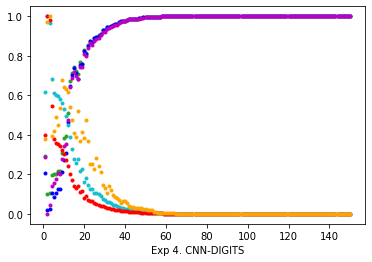

In [4]:
# loss 归一化
max_loss = 0
max_MS_loss = 0
max_train_acc = 0
max_F1 = 0
max_MCC = 0
max_Score = 0

for i in range(len(turns_record)):
    if loss_record[i] > max_loss:
        max_loss = loss_record[i]
    if MS_loss_record[i] > max_MS_loss:
        max_MS_loss = MS_loss_record[i]
    if Score_record[i] > max_Score:
        max_Score = Score_record[i]    

for i in range(len(loss_record)):
    loss_record[i] = loss_record[i]/max_loss
    MS_loss_record[i] = MS_loss_record[i]/max_MS_loss
    Score_record[i] = Score_record[i]/max_Score
    
plt.plot(turns_record, train_acc_record, '.', color = 'tab:green', label='ACC')
plt.plot(turns_record, F1_record, '.', color = 'b', label='F1') # lightpink
plt.plot(turns_record, MCC_record, '.', color = 'm', label='MCC')
plt.plot(turns_record, MS_loss_record, '.', color = 'tab:cyan', label='MS') # turquoise
plt.plot(turns_record, loss_record, '.', color = 'r', label='CE') # blueviolet
plt.plot(turns_record, Score_record, '.', color = 'orange', label='MPWS')

# plt.legend(bbox_to_anchor=(1.05, 1), loc=2)

LABEL = 'Exp 4'
plt.xlabel(f"{LABEL}. {NAME}")

plt.savefig(f'../Savefig/{LABEL}.png', bbox_inches='tight', dpi=600)  # 保存该图片
plt.show()

In [5]:
import pandas as pd

train_acc_record_df = pd.DataFrame(train_acc_record)
F1_record_df = pd.DataFrame(F1_record)
MCC_record_df = pd.DataFrame(MCC_record)
MS_loss_record_df = pd.DataFrame(MS_loss_record)
loss_record_df = pd.DataFrame(loss_record)
Score_record_df = pd.DataFrame(Score_record)

data_df = pd.concat([train_acc_record_df, F1_record_df, MCC_record_df, MS_loss_record_df, loss_record_df, Score_record_df], axis=1)
data_df.columns = ['Accuracy', 'F1-score', 'MCC', 'Mean Squared', 'Cross Entropy', 'MPWS']  # head

writer = pd.ExcelWriter(f"../Records/{LABEL}. {NAME}.xlsx")
data_df.to_excel(writer,'page_1')
writer.save()
